In [11]:
import pandas as pd
import numpy as np
from filterpy.kalman import KalmanFilter

def apply_kalman_filter(df):

    def kalman_filter(data):
        kf = KalmanFilter(dim_x=2, dim_z=1)
        kf.x = np.array([data[0], 0.0])       
        kf.F = np.array([[1.0, 1.0],
                         [0.0, 1.0]])
        kf.H = np.array([[1.0, 0.0]])
        kf.P = np.array([[1.0, 0.0],
                         [0.0, 1.0]])
        kf.R = np.array([[1.0]])
        kf.Q = np.array([[0.001, 0.0],
                         [0.0, 0.001]])
        filtered_data = []
        for z in data:
            kf.predict()
            kf.update([z])
            filtered_data.append(kf.x[0])
        return filtered_data

    df_kalman = pd.DataFrame()
    df_kalman['time']=df['Timestamp']
    for axis in ['acc_x', 'acc_y', 'acc_z']:
        df_kalman[axis] = kalman_filter(df[axis].values)
    
    return df_kalman

# Example usage

df = pd.read_csv('drum2.csv')

df_kalman = apply_kalman_filter(df)


print(df_kalman)


                           time     acc_x     acc_y     acc_z
0    2024-07-24T23:02:44.217496  0.350000 -0.340000  0.290000
1    2024-07-24T23:02:44.383509  0.643431 -0.380013  0.229980
2    2024-07-24T23:02:44.683062  0.483591 -0.231140 -0.050186
3    2024-07-24T23:02:45.041135  0.384775 -0.260562  0.023046
4    2024-07-24T23:02:45.340412  0.172259 -0.152954 -0.091246
..                          ...       ...       ...       ...
171  2024-07-24T23:03:44.021358  1.578915  1.486565  1.852432
172  2024-07-24T23:03:44.319749  0.890703 -0.511404  0.902637
173  2024-07-24T23:03:44.619540  0.324140 -2.047294  0.141705
174  2024-07-24T23:03:44.918763 -0.096395 -3.181897 -0.458225
175  2024-07-24T23:03:45.218460 -0.421085 -3.971314 -0.906159

[176 rows x 4 columns]


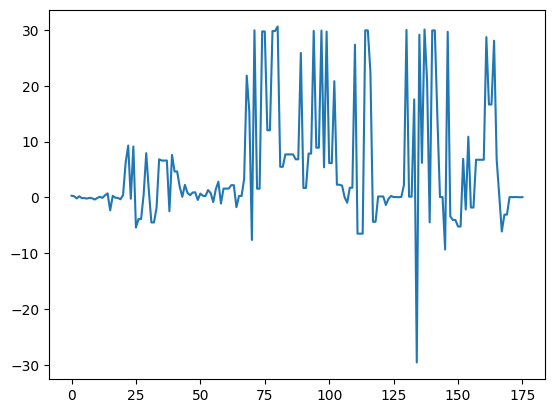

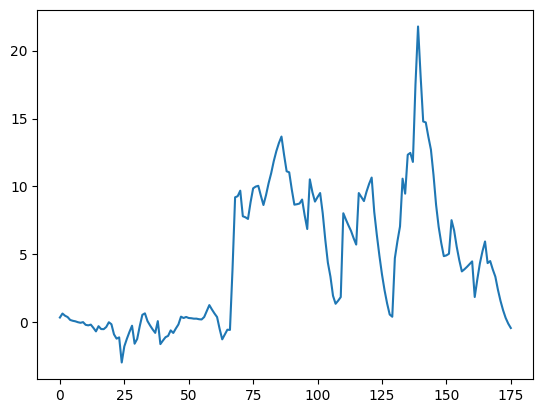

In [21]:
import matplotlib.pyplot as plt
def net_acceleration(df):
    df['net_acc'] = np.sqrt(df['acc_x']**2 + df['acc_y']**2 + df['acc_z']**2)
    return df
df=net_acceleration(df)
df_kalman=net_acceleration(df_kalman)
plt.plot(df['acc_x'])
plt.show()
plt.plot(df_kalman['acc_x'])

plt.show()

In [13]:
def apply_moving_average(df, column_name, window_size=5):
    df_filtered = df.copy()
    df_filtered[column_name] = df[column_name].rolling(window=window_size).mean()
    return df_filtered
df_y=apply_moving_average(df_kalman,'acc_z',1)

,time,acc_x,acc_y,acc_z,net_acc
0,2024-07-24T23:02:44.217496,0.350000,-0.340000,0.290000,0.567627
1,2024-07-24T23:02:44.383509,0.643431,-0.380013,0.229980,0.781860
2,2024-07-24T23:02:44.683062,0.483591,-0.231140,-0.050186,0.538335
3,2024-07-24T23:02:45.041135,0.384775,-0.260562,0.023046,0.465269
4,2024-07-24T23:02:45.340412,0.172259,-0.152954,-0.091246,0.247778


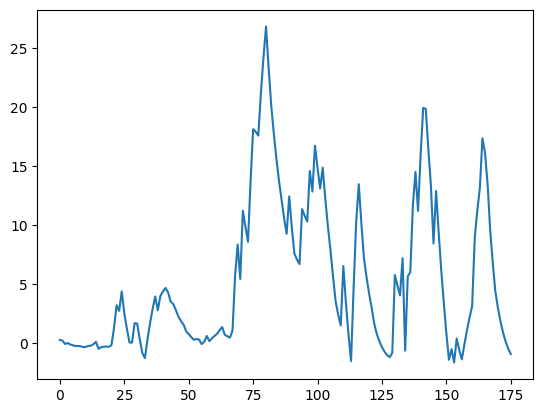

In [14]:
plt.plot(df_kalman['acc_z'])
df_kalman.dropna(inplace=True)
df_kalman.head()

[ 22  24  29  34  39  68  71  74  80  84  89  94  97  99 102 110 114 130
 133 135 137 140 146 152 154 161 164]


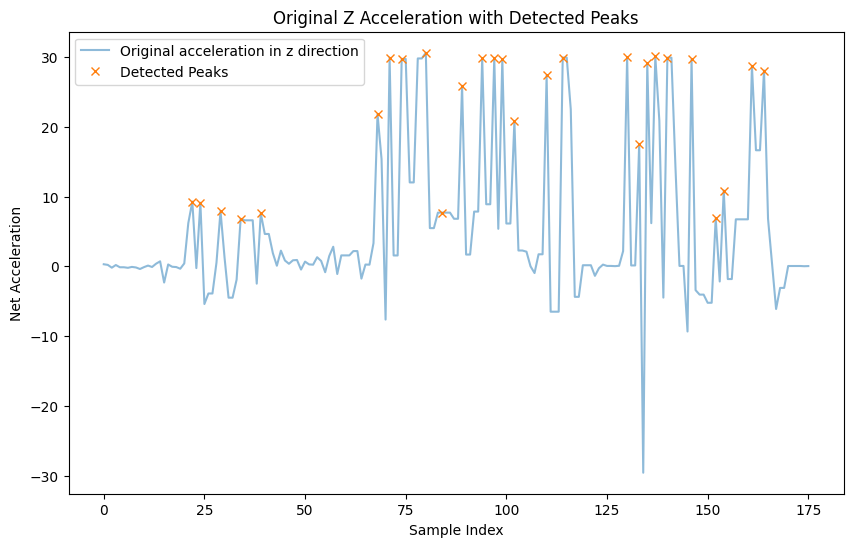

In [15]:
from scipy.signal import find_peaks,detrend
peak_height=5
peak_distance=None

def detect_peaks(df, column_name='net_acc', height=10, distance=None):
 
    peaks, _ = find_peaks(df[column_name].dropna(), height=height, distance=distance)
    return peaks
peaks = detect_peaks(df, column_name='acc_z', height=peak_height, distance=peak_distance)
print(peaks)

def plot_peaks(df,df_kalman,peaks):
    plt.figure(figsize=(10, 6))
    plt.plot( df['acc_z'], label='Original acceleration in z direction', alpha=0.5)
    # plt.plot( df_kalman['acc_z'], label='Filtered net_acc(Kalman_Filter)', color='red')
    plt.plot( df['acc_z'].iloc[peaks], "x", label='Detected Peaks')
    plt.xlabel('Sample Index')
    plt.ylabel('Net Acceleration')
    plt.title('Original Z Acceleration with Detected Peaks')
    plt.legend()
    plt.show()
plot_peaks(df,df_kalman,peaks)

df_kalman.head()
df_kalman.dropna(inplace=True)



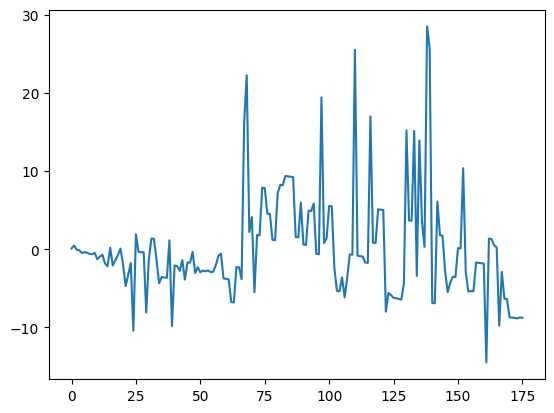

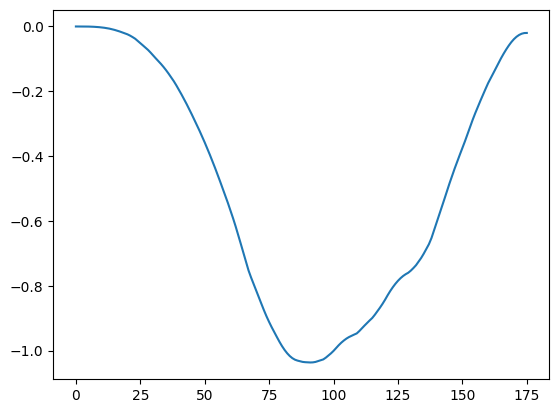

,Timestamp,acc_x,acc_y,acc_z,GyroX,GyroY,GyroZ,net_acc,v_x,v_y,v_z,x_pos,y_pos,z_pos,v_net,x_net
171,2024-07-24T23:03:44.021358,-8.743988,-24.224257,-8.071335,170.44,-38.56,-3.19,0.282843,0.345548,1.052562,0.371301,-0.031787,0.102332,0.069960,1.168399,0.127971
172,2024-07-24T23:03:44.319749,-8.791961,-24.347579,-8.104349,170.44,-38.56,-3.19,0.282843,0.257629,0.809086,0.290258,-0.026195,0.111640,0.073267,0.897353,0.136080
173,2024-07-24T23:03:44.619540,-8.839934,-24.470900,-8.137364,170.44,-38.56,-3.19,0.282843,0.169230,0.564377,0.208884,-0.022368,0.118507,0.075763,0.625134,0.142423
174,2024-07-24T23:03:44.918763,-8.727907,-24.594221,-8.200379,170.94,-39.38,-3.06,0.120416,0.081950,0.318435,0.126880,-0.020293,0.122921,0.077442,0.352442,0.146692
175,2024-07-24T23:03:45.218460,-8.765880,-24.707542,-8.213394,170.94,-39.38,-3.06,0.114455,-0.005708,0.071360,0.044746,-0.019968,0.124870,0.078300,0.084422,0.148735


In [16]:
def calculate_positions_and_velocity(df, delta_t=0.01, acc_min_threshold=-2, acc_max_threshold=2, cutoff_freq=0.1, sampling_freq=10):
    df = df.copy()
    df['v_x'] = 0.0
    df['v_y'] = 0.0
    df['v_z'] = 0.0
    df['x_pos'] = 0.0
    df['y_pos'] = 0.0
    df['z_pos'] = 0.0
    df['acc_x'] = detrend(df['acc_x'])
    df['acc_y'] = detrend(df['acc_y'])
    df['acc_z'] = detrend(df['acc_z'])
    
    
    for i in range(2, len(df)):
        acc_x = df.loc[i, 'acc_x']
        acc_y = df.loc[i, 'acc_y']
        acc_z = df.loc[i, 'acc_z']
        
        # Apply thresholding to filter out noise
        # if acc_min_threshold < acc_x < acc_max_threshold:
        #     acc_x = 0.0
        # if acc_min_threshold < acc_y < acc_max_threshold:
        #     acc_y = 0.0
        # if acc_min_threshold < acc_z < acc_max_threshold:
        #     acc_z = 0.0
        
        # Update velocities
        df.loc[i, 'v_x'] = df.loc[i-1, 'v_x'] + acc_x * delta_t
        df.loc[i, 'v_y'] = df.loc[i-1, 'v_y'] + acc_y * delta_t
        df.loc[i, 'v_z'] = df.loc[i-1, 'v_z'] + acc_z * delta_t
        
        # if i % 100 == 0:  # Adjusting every 100 steps, can be tuned
        #     df.loc[i, 'v_x'] -= np.mean(df.loc[:i, 'v_x'])
        #     df.loc[i, 'v_y'] -= np.mean(df.loc[:i, 'v_y'])
        #     df.loc[i, 'v_z'] -= np.mean(df.loc[:i, 'v_z'])
        
        # Update positions
        df.loc[i, 'x_pos'] = df.loc[i-1, 'x_pos'] + (df.loc[i-1, 'v_x']+df.loc[i,'v_x'] ) * delta_t + 0.5 * acc_x * (delta_t ** 2)
        df.loc[i, 'y_pos'] = df.loc[i-1, 'y_pos'] + df.loc[i-1, 'v_y'] * delta_t + 0.5 * acc_y * (delta_t ** 2)
        df.loc[i, 'z_pos'] = df.loc[i-1, 'z_pos'] + df.loc[i-1, 'v_z'] * delta_t + 0.5 * acc_z * (delta_t ** 2)
    
    df['v_net'] = np.sqrt(df['v_x']**2 + df['v_y']**2 + df['v_z']**2)
    df['x_net'] = np.sqrt(df['x_pos']**2 +df['y_pos']**2+ df['z_pos']**2) 
    
    return df

df_vel_disp=calculate_positions_and_velocity(df)

plt.plot(df_vel_disp['acc_x'])
plt.show()
plt.plot(df_vel_disp['x_pos'])
plt.show()
df_vel_disp.tail()


In [17]:
drum_boundaries = {
    'hihats': {'x_min': -1, 'y_min': -1, 'x_max': 0, 'y_max': 0},
    'crash': {'x_min': 0, 'y_min': 0, 'x_max': 1, 'y_max': 1},
    'hitoms': {'x_min': -1, 'y_min': 0, 'x_max': 0, 'y_max': 0},
    'lotoms': {'x_min': 0, 'y_min': 0, 'x_max': 1, 'y_max': 1},
    'ride': {'x_min': -2, 'y_min': -1, 'x_max': -1, 'y_max': 0},
    'snare': {'x_min': -2, 'y_min': 0, 'x_max': -1, 'y_max': 1}
}
df_y.head()
# Z threshold
z_threshold = -5

def find_drum_type(df, peak):
    
    detected_drum=None

    x_pos = df.loc[peak, 'x_pos']
    y_pos = df.loc[peak, 'y_pos']
    z_pos = df.loc[peak, 'z_pos']
        
    if z_pos > z_threshold:
            
        for drum, bounds in drum_boundaries.items():
            if (bounds['x_min'] <= x_pos <= bounds['x_max'] and 
                bounds['y_min'] <= y_pos <= bounds['y_max']):
                detected_drum = drum
                
                return detected_drum
            
           
    
    return detected_drum

for peak in peaks:
    print(find_drum_type(df_vel_disp,peak))
print(peaks)

hihats
hihats
hihats
hihats
hihats
hihats
hihats
hihats
hihats
None
None
ride
ride
ride
hihats
hihats
hihats
hihats
hihats
hihats
hihats
hihats
hihats
hihats
hihats
hihats
hihats
[ 22  24  29  34  39  68  71  74  80  84  89  94  97  99 102 110 114 130
 133 135 137 140 146 152 154 161 164]


In [18]:
import pygame
import os
import threading
def play_drum_sound(drum_type, sound_level):
    base_path = "samples\\%s" %(drum_type)  #path of the folder which contains the audio file
    file_name = f"{drum_type}{sound_level}.wav"   #the name of the audio file
    file_path = os.path.join(base_path, file_name)
    print(file_path)
    if os.path.exists(file_path):  #check if the file exists
        pygame.mixer.init()
        sound=pygame.mixer.Sound(file_path)
        sound.play()
    else:
        print("File not found")
        
#making a function which uses multithreading to run multiple audio files together    
def play_sound_thread(drum_type, sound_level):  
    sound_thread = threading.Thread(target=play_drum_sound, args=(drum_type, sound_level))
    sound_thread.start()

print(peaks)

[ 22  24  29  34  39  68  71  74  80  84  89  94  97  99 102 110 114 130
 133 135 137 140 146 152 154 161 164]


In [19]:
def find_drum_sound_level(df,peak):
    lvl1=5
    lvl2=8
    lvl3=11
    lvl4=13.5
    lvl5=14
    lvl6=16.5
    lvl7=17
    lvl8=18.5
    lvl9=20
    
    acceleration_Value=abs(df.loc[peak, 'acc_z'])
    print(acceleration_Value)
    
    if lvl1 <=acceleration_Value<lvl2:
        return 7
    if lvl2 <=acceleration_Value<lvl3:
        return 1
    if lvl3 <=acceleration_Value<lvl4:
        return 2
    if lvl4 <=acceleration_Value<lvl5:
        return 3
    if lvl5 <=acceleration_Value<lvl6:
        return 4
    if lvl6 <=acceleration_Value<lvl7:
        return 5
    if lvl7 <=acceleration_Value<lvl8:
        return 6
    if lvl8 <=acceleration_Value<lvl9:
        return 7
            
print(peaks)


[ 22  24  29  34  39  68  71  74  80  84  89  94  97  99 102 110 114 130
 133 135 137 140 146 152 154 161 164]


In [20]:
# print(peaks)
import time
def give_drumtype_and_level(df,peaks):
    pygame.init()
    pygame.mixer.init()
    for peak in peaks:
        
        drum_type=find_drum_type(df,peak)
        sound_level=find_drum_sound_level(df,peak)
        print(peak,drum_type,sound_level)
        play_sound_thread(drum_type,sound_level)


